### Credits : https://github.com/lukysummer/Movie-Review-Sentiment-Analysis-LSTM-Pytorch/blob/master/sentiment_analysis_LSTM.py

### Dataset from https://ai.stanford.edu/~amaas/data/sentiment/

In [1]:
# loading basic libraries
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from string import punctuation
import torch
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /home/u33552/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#loading the dataset
review_data = pd.read_excel('movie_data.xlsx')
review_data.replace(pd.np.nan,'',inplace=True,regex=True)
review_data.head()

,review,label
0,it's a lovely movie it deeply reflects the Chi...,1
1,This 1998 film was based on a script by the la...,1
2,If you're going to put on a play within the pr...,1
3,At first sight this movie doesn't look like a ...,1
4,This adaptation of M.R. James's short story 'A...,1


In [3]:
# lets preprocess the data to remove punctuations and special characters. 
# Here wer removed everything that is not a character from a-z both lowercase and uppercase
# here we are also converting all the words to lowercase

review_data['review'] = review_data['review'].str.replace("[^a-zA-Z]"," ").apply(lambda x: str(x).lower())

In [4]:
#loading nltk stopwords for english
from nltk.corpus import stopwords
stopwords_english = stopwords.words('english')

In [5]:
# removing all words stopwords. We will use the nltk library list of stop words

review_data['review'] = review_data['review'].apply(lambda x:' '.join([word for word in str(x).split() if word not in stopwords_english ]))
review_data['review'].head()

0    lovely movie deeply reflects chinese undergrou...
1    film based script late edward wood script feat...
2    going put play within prison walls go top play...
3    first sight movie look like particular great o...
4    adaptation r james short story view hill first...
Name: review, dtype: object

In [6]:
#removing the words with length less than or equal to 2
review_data['review'] = review_data['review'].apply(lambda x:' '.join([word for word in str(x).split() if len(word)>2 ]))


In [7]:
review_data['review'].head()
# data looks good now

0    lovely movie deeply reflects chinese undergrou...
1    film based script late edward wood script feat...
2    going put play within prison walls top playwri...
3    first sight movie look like particular great o...
4    adaptation james short story view hill first s...
Name: review, dtype: object

In [8]:
# lets visualize most common words with wordcloud
# We will do visualization for both negative and positive labels as well as the whole data corpus itself


In [9]:
all_words = ' '.join(review_data['review'].tolist())
negative_words = ' '.join(review_data['review'][review_data['label']==0].tolist())
positive_words = ' '.join(review_data['review'][review_data['label']==1].tolist())

In [10]:
#defining a function that will generate word cloud for us

def generate_wordcloud(text,title):
    wc = WordCloud(width=800, height=400, max_font_size=110)
    wc.generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()


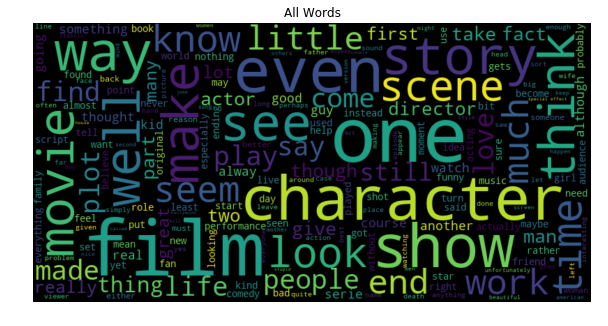

In [11]:
generate_wordcloud(all_words,'All Words')

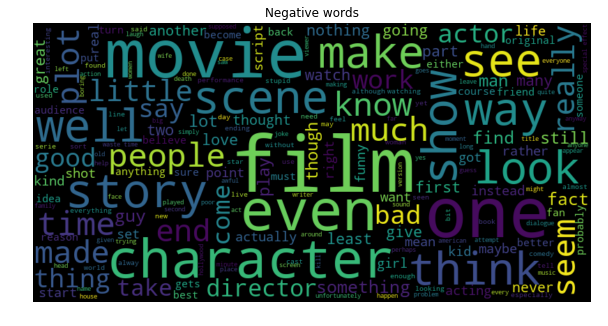

In [12]:
generate_wordcloud(negative_words,'Negative words')

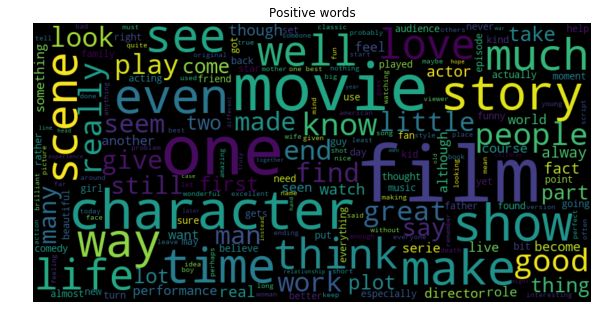

In [13]:
generate_wordcloud(positive_words,'Positive words')

## Create dictionaries and encode reviews

In [14]:
from collections import Counter
word_counts = Counter(all_words.split())
#sorted word list according to descending order. i.e biggest on at first position and so on
word_list = sorted(word_counts, key = word_counts.get, reverse = True)
# creating two dictionaries to map. word to index and map index to word.
# example 1--> movie-->1 --> word to index
# example 2--> movie --> index to word
word_to_index = {word:idx+1 for idx,word in enumerate(word_list)}
index_to_word = {idx+1:word for idx,word in enumerate(word_list)}

In [15]:
#encoding reviews
encoded_reviews = [[word_to_index[word] for word in review.split()] for review in review_data['review']]

## Encode label

In [16]:
encoded_labels = review_data['label']

In [17]:
# len of reviews should be equal to length of labels
assert len(encoded_reviews)==len(encoded_labels),"Number of of encoded reviews and encoded labels should be same"

### Removing empty reviews and labels--> i.e those reviews that had no text.--> they will have empty list in encoded matrix

In [18]:
encoded_labels = np.array([label for idx, label in enumerate(encoded_labels) if len(encoded_reviews[idx])>0])
encoded_reviews =  [review for review in encoded_reviews if len(review)>0]


In [19]:
# len of reviews should be equal to length of labels
assert len(encoded_reviews)==len(encoded_labels),"Number of of encoded reviews and encoded labels should be same"

### Making all reviews of same length i.e padding

In [20]:
#printing top 20 max length
len_max = ([len(x) for x in encoded_reviews])
print(sorted(list(len_max),reverse=True)[:20])

[1390, 1132, 1127, 1080, 920, 905, 889, 870, 802, 789, 787, 772, 727, 701, 690, 684, 673, 669, 629, 625]


In [21]:
# lets see how many reviews have text more than 500
len([review for review in len_max if review>499])

233

In [22]:
# lets see how many reviews have text more than 250
len([review for review in len_max if review>249])

4139

In [23]:
# lets see how many reviews have text more than 150
len([review for review in len_max if review>149])

11458

In [24]:
# lets see how many reviews have text more than 100
len([review for review in len_max if review>99])

20754

In [25]:
# lets see how many reviews have text less than 100
len([review for review in len_max if review<100])

29243

looks like majority of reviews have length less than 100. 

so a standard size of 250 should be enough to get all the features of a review.

also probably people will have expressed how they feel in their first 250 words.

so lets fix a standard review size of 250. in case if reviews are short. we will pad zeros. 

and in case reviews are long we will truncate them

In [26]:
# function to pad our encoded reviews/feature
def pad_features(reviews,max_length):
    """
    Return features of reviews where each review is padded with 0's or truncted to the max_length
    """
    
    features = []
    
    #pad or truncate each review
    for idx,row in enumerate(reviews):
        if len(row)>=max_length:
            features.append(row[:max_length])
        else:
            features.append(np.concatenate((np.zeros(max_length-len(row)),np.array(row))))
        
    return np.array(features)

In [27]:
test_array = [[1,2,3,4],
    [1,2,3,4,5,6,7,8,9,10]]
pad_features(test_array,8)

array([[0., 0., 0., 0., 1., 2., 3., 4.],
       [1., 2., 3., 4., 5., 6., 7., 8.]])

In [28]:
# padding our reviews.We are calling our reviews features because 
# it makes sense to call it feature now as we will feed this feature to our model later
padded_features = pad_features(reviews = encoded_reviews,max_length = 250)

In [29]:
# checking if the number of feature is equal to number of reviews we passed
assert len(padded_features) == len(encoded_reviews),"Length Mismatch after padding"
assert len(padded_features[0]) == 250

## Splitting our data into training and testing set

In [30]:
total = padded_features.shape[0]
train_ratio = 0.8
# the plan is to use 80% of data for training and use remaining 20% for testing and validation
# we will split the remaining 20% into half and seperate into testing and validation sets
train_idx = int(total*0.8) #39997
train_x, remaining_x  = padded_features[:train_idx],padded_features[train_idx:]
train_y, remaining_y   = encoded_labels[:train_idx],encoded_labels[train_idx:]

#splitting the remaining 20% to validation and testing
test_idx = int(len(remaining_x)*0.5)
test_x,valid_x  = remaining_x[:test_idx],remaining_x[test_idx:]
test_y,valid_y = remaining_y[:test_idx],remaining_y[test_idx:]


In [31]:
#lets see the shape of our training,validation and testing data
print("\t\t\t Features Shape")
print("Train Set:\t\t{}".format(train_x.shape),
     "\nValidation Set:\t\t{}".format(valid_x.shape),
     "\nTesting Set\t\t{}".format(test_x.shape))

			 Features Shape
Train Set:		(39997, 250) 
Validation Set:		(5000, 250) 
Testing Set		(5000, 250)


In [32]:
#lets see the shape of labels for out training, validation and testing data
print("\t\t\t Label Shape")
print("Train Set:\t\t{}".format(train_y.shape),
     "\nValidation Set:\t\t{}".format(valid_y.shape),
     "\nTesting Set\t\t{}".format(test_y.shape))

			 Label Shape
Train Set:		(39997,) 
Validation Set:		(5000,) 
Testing Set		(5000,)


In [33]:
print('Total data After preprocessing: \nFeatures:{}\nLabels:{}'.format(padded_features.shape,encoded_labels.shape))

Total data After preprocessing: 
Features:(49997, 250)
Labels:(49997,)


In [34]:
## 80% of 49997 = 39997 approx
## 10% of 49997 = 5000 approx
## math checks out

### Loading the dataset and batching into DataLoaders


* we will use TensorDataset and DataLoader for this purpose
* TensorDataset takes Features and Labels with same dimension and creates a dataset
* DataLoader makes our Dataset into generator that will give us both features and labels in batch sizes

`train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))`

`train_loader = DataLoader(train_data, batch_size=batch_size)`

In [35]:
from torch.utils.data import TensorDataset, DataLoader


# create TensorDatasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data =  TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


batch_size = 25

#we will shuffle the data because if we remember our data was like first 25k were positive and the second 25k were negative
#this might result in biasness
train_loader = DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_loader = DataLoader(valid_data,shuffle=True,batch_size=batch_size)
test_loader = DataLoader(test_data,shuffle=True,batch_size=batch_size)

In [36]:
# lets visualize a batch of training data

dataiter = iter(train_loader)
sample_x,sample_y = dataiter.next()
print('Sample input size:{}'.format(sample_x.size()))
print('Sample Input:\n{}\n'.format(sample_x))
print('Sample Label size:{}'.format(sample_y.size()))
print('Sample Label:\n{}'.format(sample_y))


Sample input size:torch.Size([25, 250])
Sample Input:
tensor([[   0.,    0.,    0.,  ...,  857.,   79.,  304.],
        [   0.,    0.,    0.,  ...,    8.,  834.,   17.],
        [   0.,    0.,    0.,  ...,  161.,   54.,  525.],
        ...,
        [   0.,    0.,    0.,  ...,  565.,   39., 1387.],
        [   0.,    0.,    0.,  ...,  284., 5983., 2743.],
        [   0.,    0.,    0.,  ...,  570., 5058.,  656.]], dtype=torch.float64)

Sample Label size:torch.Size([25])
Sample Label:
tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1])


## Defining our LTSM model

In [37]:
#checking if GPU is available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('Training on GPU')
else:
    print("Training on CPU")

Training on CPU


In [38]:
# building our model RNN
from torch import nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform sentiment analysis.
    """
    
    def __init__(self, vocab_size,output_size,embedding_dim,hidden_dim,n_layers,drop_prob = 0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        #embedding and lstm layers
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = drop_prob, batch_first = True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        
    def forward(self, x, hidden):
        
        """
        Perform a forward pass of our model on some input and hidden state
        """
        batch_size = x.size(0)
        
        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds,hidden)
        
        # stackup the lstm outputs
        lstm_out = lstm_out.contiguous().view(-1,self.hidden_dim)
        
        # dropout and fully connected layers
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        #sigmoid function
        sig_out = self.sig(out)
        
        # reshape the batch size first
        sig_out = sig_out.view(batch_size,-1)
        sig_out = sig_out[:,-1] # get the last batch of labels
        
        # return the last sigmoid output and hidden state
        
        return sig_out, hidden
    
    def init_hidden(self,batch_size):
        
        """ Initializes the hidden state"""
        # create two new tensors with sizes n_layers * batch_size * hidden_dim
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                     weight.new(self.n_layers, batch_sizeize, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                     weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden
        
        

## Instantiate the network

Here, we'll instantiate the network. First up, defining the hyperparameters.

* vocab_size: Size of our vocabulary or the range of values for our input, word tokens.
* output_size: Size of our desired output; the number of class scores we want to output (pos/neg).
* embedding_dim: Number of columns in the embedding lookup table; size of our embeddings.
* hidden_dim: Number of units in the hidden layers of our LSTM cells. Usually larger is better performance wise. * * Common values are 128, 256, 512, etc.
* n_layers: Number of LSTM layers in the network. Typically between 1-3

In [39]:
# instantiate our model with hyper parameters

vocab_size = len(word_to_index)+1
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(104401, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Training

In [ ]:

# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [ ]:
# training params

valid_loss_min = np.Inf
epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            
            # lets save the model with best validation accuracy. 
            # It makes sense that we shouldnot need to train the model everytime.
            if np.mean(val_losses) <= valid_loss_min:
                print('Validation loss decreased ({:.6f} ---------> {:.6f}).\t Saving model...'.
                      format(valid_loss_min, np.mean(val_losses)))
                torch.save(net.state_dict(),'./best_validation.pt')
                valid_loss_min = np.mean(val_losses)
                
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Validation loss decreased (0.962751 ---------> inf).	 Saving model...
Epoch: 1/4... Step: 100... Loss: 0.496569... Val Loss: 0.962751
Validation loss decreased (0.566605 ---------> 0.962751).	 Saving model...
Epoch: 1/4... Step: 200... Loss: 0.405546... Val Loss: 0.566605


In [ ]:

# load the model that got the best validation accuracy
net.load_state_dict(torch.load('best_validation.pt')